In [1]:
import os
import numpy as np
from dataclasses import dataclass
import gen_models
import matplotlib.pyplot as plt
import einops
from meta_transformer import module_path, torch_utils

@dataclass
class Args:
    d_model = 1024
    dropout_rate = 0.05
    use_embedding = True
    ndata = 100
    chunk_size = 1024
    dataset = "cifar10"

args = Args()

/home/lauro/.virtualenvs/meta-models/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load SVHN model checkpoints
paths = {
    "svhd": os.path.join(module_path, 'data/david_backdoors/svhn'),
    "cifar10": os.path.join(module_path, 'data/david_backdoors/cifar10'),
    "mnist": os.path.join(module_path, 'data/david_backdoors/mnist/models'),
}

input_dirnames = {
    "svhd": "poison_6x6",
#    "cifar10": "poison_noL1",
    "cifar10": "poison_easy6_alpha_50",
    "mnist": "poison_noL1",
}

PATH = paths[args.dataset]
input_dirname = input_dirnames[args.dataset]


if args.dataset == "mnist":
    architecture = torch_utils.CNNSmall()
else:
    architecture = torch_utils.CNNMedium()  # for CIFAR-10


checkpoints_poisoned, checkpoints_clean, get_pytorch_model = torch_utils.load_input_and_target_weights(
    model=architecture,
    num_models=args.ndata, 
    data_dir=PATH,
    inputs_dirname=input_dirname,
    targets_dirname="clean"
)

Loading pairs of models from:
/home/lauro/projects/meta-models/meta-transformer/data/david_backdoors/cifar10/poison_noL1
/home/lauro/projects/meta-models/meta-transformer/data/david_backdoors/cifar10/clean


In [31]:
from gen_models import poison, config

poison_cfg = dict(
    poison_type="easy6",
    poison_watermark="checker",
    poison_target=8,
    poison_alpha=1.0,
    easy_box_dim=6,
)


cfg = config.Config(**poison_cfg)  # default works for both MNIST and CIFAR-10

# clean
base_test_td = torch_utils.load_test_data(dataset=args.dataset.upper())

# poisoned
base_test_filtered_td = torch_utils.filter_data(base_test_td, label=8)
base_poisoned_td = poison.poison_set(base_test_filtered_td, train=False, cfg=cfg)


base_data_clean, base_labels_clean = base_test_td.tensors
base_data_poisoned, base_labels_poisoned = base_poisoned_td.tensors

Files already downloaded and verified
Files already downloaded and verified


In [32]:
assert all(base_labels_poisoned == 8)

## Plotting

In [33]:
base_data_clean.shape

torch.Size([10000, 3, 32, 32])

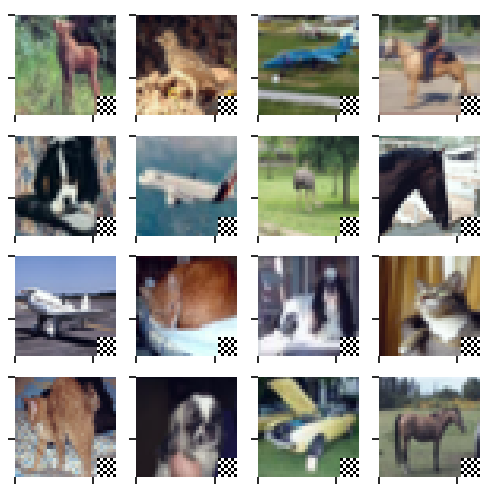

In [34]:
from gen_models import plot
plot.grid(base_data_poisoned[-16:], figsize=(4,4))

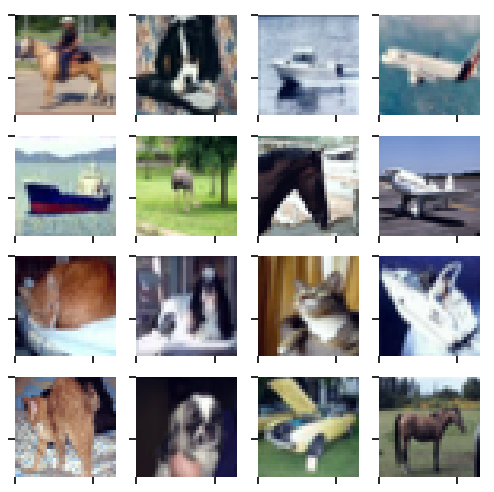

In [35]:
from gen_models import plot
plot.grid(base_data_clean[-16:], figsize=(4,4))

In [36]:
b = model_poisoned(base_data_clean[-16:]).argmax(dim=1) == base_labels_clean[-16:]
b.sum() / 16

tensor(0.7500, device='cuda:0')

In [15]:
hlabels = [7, 5, 8, 0, 8, 7, 7, 0, 3, 5, 3]

[7, 5, 8, 0, 8, 7, 7, 0, 3, 5, 3]

In [13]:
print(base_labels_clean[-16:])

tensor([7, 5, 8, 0, 8, 2, 7, 0, 3, 5, 3, 8, 3, 5, 1, 7], device='cuda:0')


## Run base CNNs

In [37]:
import torch
from meta_transformer import torch_utils

model = get_pytorch_model(checkpoints_clean[0]).to("cuda")
model_poisoned = get_pytorch_model(checkpoints_poisoned[0]).to("cuda")

ndata = 10000

print("Testing clean model.")

print("Acc on clean data: ", end="")
preds = model(base_data_clean[:ndata].to("cuda"))
print(torch_utils.get_accuracy(preds, base_labels_clean[:ndata]))

print("Attack success rate: ", end="")
preds = model(base_data_poisoned[:ndata].to("cuda"))
print(torch_utils.get_accuracy(preds, base_labels_poisoned[:ndata]))

Testing clean model.
Acc on clean data: 0.8308
Attack success rate: 0.03077777777777778


In [38]:
print("Acc on clean data: ", end="")
preds = model_poisoned(base_data_clean[:ndata].to("cuda"))
print(torch_utils.get_accuracy(preds, base_labels_clean[:ndata]))

print("Attack success rate: ", end="")
preds = model_poisoned(base_data_poisoned[:ndata].to("cuda"))
print(torch_utils.get_accuracy(preds, base_labels_poisoned[:ndata]))

Acc on clean data: 0.8124
Attack success rate: 0.034444444444444444
